In [5]:
import numpy as np
import pandas as pd

In [2]:
from astroquery.gaia import Gaia

First I will try it on the biggest field of view and then I will query the found result for subsets of it

In [61]:
f = 8.3e9
l = (c := 299_792_458) / f
D = 13.5
theta = 1.22 * l / D ; radius = theta * 180 / np.pi / 2

In [7]:
f"θ_FOV = {theta * 180 / np.pi * 60 :.2f} arcminutes"

'θ_FOV = 11.22 arcminutes'

In [10]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time

# Galactic Center in galactic coords
gc_gal = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')

# Convert to ICRS (J2016)
gc_icrs = gc_gal.transform_to('icrs')
gc_icrs.location = None  # makes sure it's barycentric
gc_icrs.obstime = Time('J2016.0')

gc_icrs.ra.deg, gc_icrs.dec.deg

(np.float64(266.4049882865447), np.float64(-28.936177761791473))

In [20]:
radius = 0.1 # fov 12 arcminutes

In [21]:
query = f"""
SELECT *
FROM gaiadr3.gaia_source
WHERE CONTAINS(
  POINT('ICRS', ra, dec),
  CIRCLE('ICRS', {gc_icrs.ra.deg}, {gc_icrs.dec.deg}, {radius})
) = 1
"""

In [22]:
job = Gaia.launch_job_async(query)

INFO: Query finished. [astroquery.utils.tap.core]


In [23]:
results = job.get_results()
print(results)

    solution_id             designation          ... libname_gspphot
                                                 ...                
------------------- ---------------------------- ... ---------------
1636148068921376768 Gaia DR3 4057469966902826112 ...           MARCS
1636148068921376768 Gaia DR3 4057469971197249024 ...                
1636148068921376768 Gaia DR3 4057469971208053760 ...                
1636148068921376768 Gaia DR3 4057470001262567680 ...         PHOENIX
1636148068921376768 Gaia DR3 4057470001262569728 ...           MARCS
1636148068921376768 Gaia DR3 4057470001262571008 ...         PHOENIX
1636148068921376768 Gaia DR3 4057470001263255680 ...                
1636148068921376768 Gaia DR3 4057470001263259136 ...         PHOENIX
1636148068921376768 Gaia DR3 4057470001263456128 ...                
                ...                          ... ...             ...
1636148068921376768 Gaia DR3 4057492889150413696 ...           MARCS
1636148068921376768 Gaia DR3 40574

In [34]:
# Gaia sources in SkyCoord format
sources = SkyCoord(ra=results['ra'], dec=results['dec'], frame='icrs')

# Angular separation from GC in arcminutes
separations = sources.separation(gc_gal).arcminute

In [57]:
counts, bin_edges = np.histogram(separations, bins=100)
for i in range(1, len(counts)):
    counts[i] += counts[i-1]
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

In [58]:
r_min = 3.02  # radius for fov for 15.4 GHz
r_max = 5.61  # radius for fov for  8.3 GHz

# Create colors: highlight bins in the target range
colors = ['crimson' if r_min <= center <= r_max else '#007847' for center in bin_centers]

/tmp/ipykernel_16044/2571871674.py:10: RuntimeWarning: divide by zero encountered in divide
  return c / (D * theta_FOV / 1.22) / 1e9


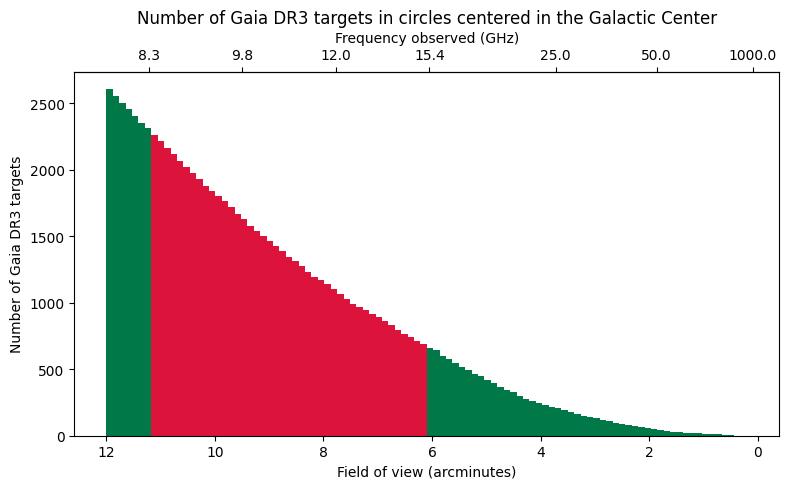

In [107]:
plt.figure(figsize=(8, 5))
plt.bar(bin_centers*2, counts, width=2*np.diff(bin_edges), color=colors, align='center')
plt.xlabel("Field of view (arcminutes)")
plt.ylabel("Number of Gaia DR3 targets")
plt.title("Number of Gaia DR3 targets in circles centered in the Galactic Center")
plt.gca().invert_xaxis()
 
def angle_to_freq(theta):
    theta_FOV = theta / 60 * np.pi/180
    return c / (D * theta_FOV / 1.22) / 1e9
    
def freq_to_angle(f):
    theta_FOV = 1.22 * (c/f) / D
    return theta_FOV * 180/np.pi * 60 / 1e9

secax = plt.gca().secondary_xaxis('top', functions=(freq_to_angle, angle_to_freq))
secax.set_xlabel("Frequency observed (GHz)")

# Format frequency ticks if needed
m1 = (2*freq_to_angle(8.3) + freq_to_angle(15.4))/3
m2 = (freq_to_angle(8.3) + 2*freq_to_angle(15.4))/3
secax.set_xticks([8.3, angle_to_freq(m1), angle_to_freq(m2), 15.4, 25, 50, 1000])  # Optional: select key ticks

plt.tight_layout()
plt.savefig("gaia_dr3_targets_in_gc_per_fov.png")
plt.show()

Red marks MeerKAT's band 5b fields of view